In [414]:
import numpy as np
import scipy.signal 
import matplotlib.pyplot as plt
import scipy.io.wavfile
import io 
import IPython
from IPython.display import Image
import math
import soundfile as sf
import pandas as pd


# 1. CPP function 

In [415]:
def cpp(x, fs, normOpt, dBScaleOpt): 
    """
    Computes cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    normOpt: string
        'line', 'mean' or 'nonorm' for selecting normalisation type
    dBScaleOpt: binary
        True or False for using decibel scale

    Returns
    -----------
    cpp: ndarray
        The CPP with time values 
    """
    # Settings
    frame_length = int(np.round_(0.04*fs))
    frame_shift = int(np.round_(0.01*fs))
    half_len = int(np.round_(frame_length/2))
    x_len = len(x)
    frame_len = half_len*2 + 1
    NFFT = 2**(math.ceil(np.log(frame_len)/np.log(2)))
    quef = np.linspace(0, frame_len/1000, NFFT)
    
    # Allowed quefrency range
    pitch_range=[60, 333.3]
    quef_lim = [int(np.round_(fs/pitch_range[1])), int(np.round_(fs/pitch_range[0]))]
    quef_seq = range(quef_lim[0]-1, quef_lim[1])
    
    # Time samples
    time_samples = np.array(range(frame_length+1, x_len-frame_length+1, frame_shift))
    N = len(time_samples)
    frame_start = time_samples-half_len
    frame_stop = time_samples+half_len
    
    # High-pass filtering
    HPfilt_b = [1 - 0.97]
    x = scipy.signal.lfilter( HPfilt_b, 1, x )
    
    # Cepstrum
    frameMat = np.zeros([NFFT, N])
    for n in range(0, N):
        frameMat[0: frame_len, n] = x[frame_start[n]-1:frame_stop[n]]
    SpecMat = np.abs(np.fft.fft(frameMat, axis=0))
    SpecdB = 20*np.log10(SpecMat)
    if dBScaleOpt:
        ceps = 20*np.log10(np.abs(np.fft.fft(SpecdB, axis=0)))
    else:
        ceps = 2*np.log(np.abs(np.fft.fft(SpecdB, axis=0)))

    # Finding the peak
    ceps_lim = ceps[quef_seq, :]
    ceps_max = ceps_lim.max(axis=0)
    max_index = ceps_lim.argmax(axis=0)
    
    # Normalisation
    ceps_norm = np.zeros([N])
    if normOpt=='line':
        for n in range(0, N):
            p = np.polyfit(quef_seq, ceps_lim[:,n],1)
            ceps_norm[n] = np.polyval(p, quef_seq[max_index[n]])
    elif normOpt == 'mean':
        ceps_norm = np.mean(ceps_lim)

    cpp = ceps_max-ceps_norm
    
    return cpp, time_samples


In [416]:
signal, fs = sf.read('data_input_rainbow.wav')
cpp_0, time_samples_0 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_0']).iloc[:len(cpp_0)]
cpp_data['CPP_python'] = cpp_0

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_0']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_0']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data


Mean Percentage Error in CPP Calculation: -8.834065657696032e-11


,CPP_matlab_0,CPP_python,Percentage Error
0,34.721052,34.721052,6.451213e-09
1,26.005789,26.005789,7.675842e-10
2,39.061011,39.061011,9.099369e-09
3,36.593516,36.593516,3.615323e-09
4,34.009892,34.009892,-1.383371e-08
...,...,...,...
63,25.680352,25.680352,-1.359164e-08
64,33.567636,33.567636,4.415751e-09
65,29.124540,29.124540,1.075621e-08
66,16.111899,16.111899,5.269392e-09


# 2. CPP plot function using matlab implementation

In [419]:
def cpp_plot(x, fs, normOpt, dBScaleOpt): 
    """
    Plots cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    normOpt: string
        'line', 'mean' or 'nonorm' for selecting normalisation type
    dBScaleOpt: binary
        True or False for using decibel scale

    """
    
    # Settings
    frame_length = int(np.round_(0.04*fs))
    frame_shift = int(np.round_(0.01*fs))
    half_len = int(np.round_(frame_length/2))
    x_len = len(x)
    frame_len = half_len*2 + 1
    NFFT = 2**(math.ceil(np.log(frame_len)/np.log(2)))
    quef = np.linspace(0, frame_len/1000, NFFT)
    
    # Allowed quefrency range
    pitch_range=[60, 333.3]
    quef_lim = [int(np.round_(fs/pitch_range[1])), int(np.round_(fs/pitch_range[0]))]
    quef_seq = range(quef_lim[0]-1, quef_lim[1])
    
    # Time samples
    time_samples = np.array(range(frame_length+1, x_len-frame_length+1, frame_shift))
    N = len(time_samples)
    frame_start = time_samples-half_len
    frame_stop = time_samples+half_len
    
    # High-pass filtering
    HPfilt_b = [1 - 0.97]
    x = scipy.signal.lfilter( HPfilt_b, 1, x )
    
    # Cepstrum
    frameMat = np.zeros([NFFT, N])
    for n in range(0, N):
        frameMat[0: frame_len, n] = x[frame_start[n]-1:frame_stop[n]]
    SpecMat = np.abs(np.fft.fft(frameMat, axis=0))
    SpecdB = 20*np.log10(SpecMat)
    if dBScaleOpt:
        ceps = 20*np.log10(np.abs(np.fft.fft(SpecdB, axis=0)))
    else:
        ceps = 2*np.log(np.abs(np.fft.fft(SpecdB, axis=0)))

    # Finding the peak
    ceps_lim = ceps[quef_seq, :]
    ceps_max = ceps_lim.max(axis=0)
    max_index = ceps_lim.argmax(axis=0)
    
    # Normalisation
    ceps_norm = np.zeros([N])
    if normOpt=='line':
        for n in range(0, N):
            p = np.polyfit(quef_seq, ceps_lim[:,n],1)
            ceps_norm[n] = np.polyval(p, quef_seq[max_index[n]])
    elif normOpt == 'mean':
        ceps_norm = np.mean(ceps_lim)

    cpp = ceps_max-ceps_norm
    cpp = [cpp, time_samples]
    
    # Plotting
    # selecting windows
    windows = [32, 44]
    
    # Full waveform plot with windows marked
    f, a = plt.subplots(figsize=(12,4))
    a.plot(x)
    for n in range(0, N):
        a.axvline(frame_start[n], color='k', alpha=0.5)
        a.axvline(frame_stop[n], color='k', alpha=0.9)  
    for n in windows:
        a.fill_between(range(frame_start[n]-1,frame_stop[n]), np.min(x), np.max(x), where=range(frame_start[n]-1,frame_stop[n]), color='skyblue', alpha=0.5)
    f.suptitle('Full waveform plot with windows marked', fontsize=16)
    a.set_xlabel('Points in the signal array')
    a.set_ylabel('Amplitude')
    
    # Waveform plot for each window
    fi_w, ax_w = plt.subplots(len(windows), 1, figsize=(12, 8))
    for i in range(len(windows)):
        ax_w[i].plot(frameMat[:, windows[i]]) 
        ax_w[i].set_xlabel('Points in the array')
        ax_w[i].set_ylabel('Amplitude')
    fi_w.suptitle('Waveform plots for each window', fontsize=16)
    
    # Plotting ceps and ceps_lim for each window
    fi, ax = plt.subplots(len(windows), 1, figsize=(12, 8))
    for i in range(len(windows)):
        ax[i].plot(ceps[:, windows[i]])
        ax[i].plot(quef_seq, ceps_lim[:, windows[i]])
        ax[i].set_xlabel('Points in the array')
        ax[i].set_ylabel('Log Magnitude (in dB)')
    fi.suptitle('ceps and ceps_lim for each window', fontsize=16)
     
    # Plotting ceps_lim, trend line, and ceps_max for each window
    fi_c, ax_c = plt.subplots(len(windows), 1, figsize=(12, 8))
    for i in range(len(windows)):
        ax_c[i].plot(ceps_lim[:, windows[i]])
        p = np.polyfit(quef_seq, ceps_lim[:,windows[i]],1)
        ax_c[i].plot(range(len(ceps_lim)), np.poly1d(p)(range(len(ceps_lim))), c='r')
        ax_c[i].plot(max_index[windows[i]], ceps_max[windows[i]], marker="o",markeredgecolor="red", markerfacecolor="red")
        ax_c[i].set_xlabel('Points in the array')
        ax_c[i].set_ylabel('Log Magnitude (in dB)')
    fi_c.suptitle('ceps_lim, trend line, and ceps_max for each window', fontsize=16)


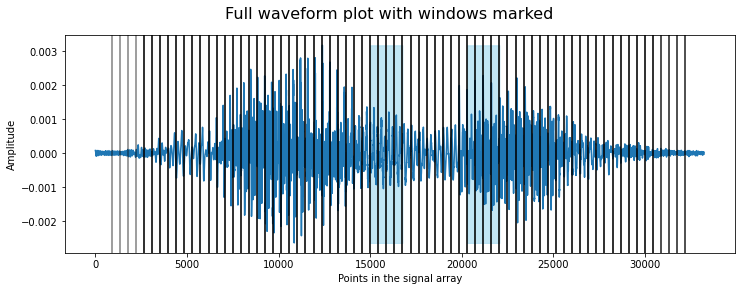

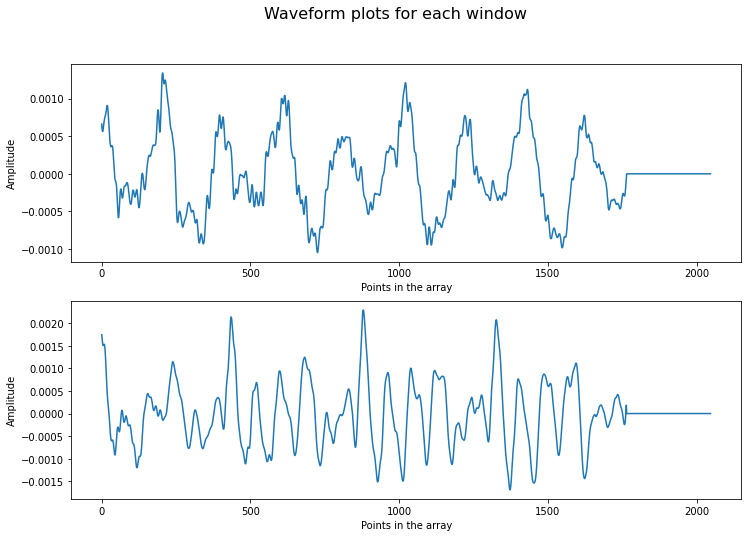

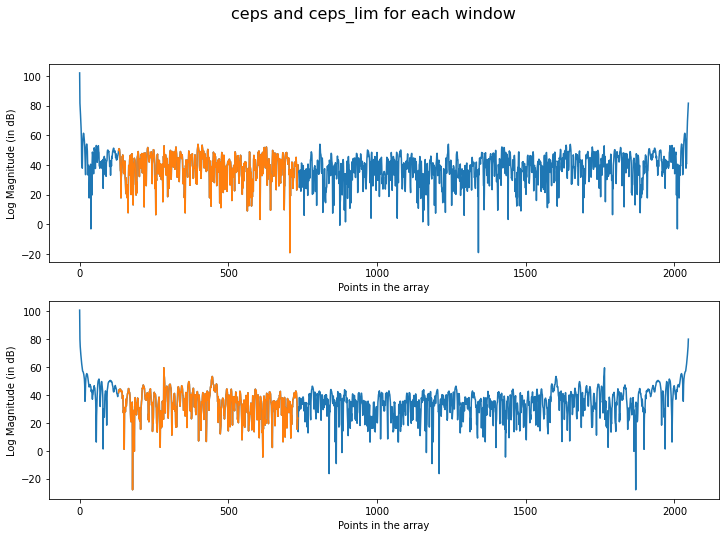

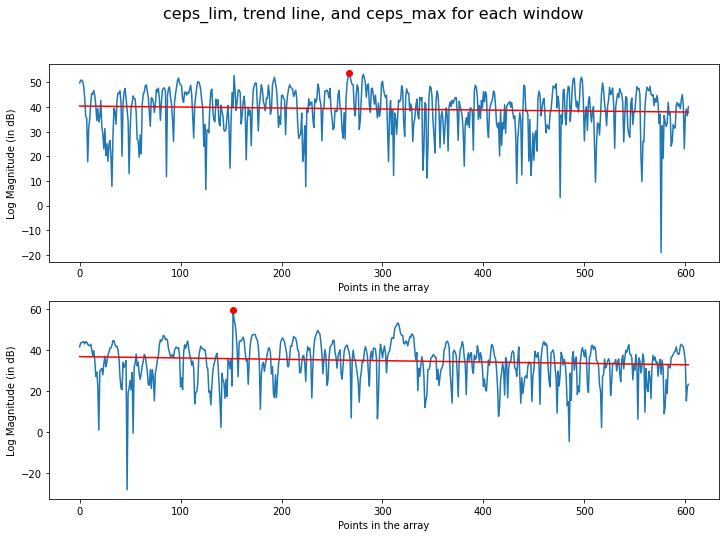

In [420]:
cpp_plot(signal, fs, 'line', True)

# 3. Examples (speech segments)

Speech segments (2 female and 2 male) taken from open speech repository (https://www.voiptroubleshooter.com/open_speech/american.html). All files are between 30-45 s.

## Example 1: f_1.wav

### CPP function

In [422]:

signal, fs = sf.read('f_1.wav')
cpp_3, time_samples_3 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_3']).iloc[:len(cpp_3)]
cpp_data['CPP_python'] = cpp_3

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_3']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_3']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data


<ipython-input-415-79091fed9bca>:50: RuntimeWarning: divide by zero encountered in log10
  SpecdB = 20*np.log10(SpecMat)


Mean Percentage Error in CPP Calculation: -3.695490173007179e-10


,CPP_matlab_3,CPP_python,Percentage Error
0,15.411517,15.411517,-3.486965e-09
1,15.774527,15.774527,1.746024e-08
2,12.330758,12.330758,3.147834e-09
3,16.473947,16.473947,2.858833e-08
4,12.321262,12.321262,-2.034690e-08
...,...,...,...
3100,13.369300,13.369300,1.550979e-08
3101,15.726970,15.726970,2.586057e-08
3102,11.733127,11.733127,-2.183911e-08
3103,16.392300,16.392300,-1.152374e-08


## Example 2: f_2.wav

### CPP function

In [423]:
signal, fs = sf.read('f_2.wav')
cpp_4, time_samples_4 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_4']).iloc[:len(cpp_4)]
cpp_data['CPP_python'] = cpp_4

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_4']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_4']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data




<ipython-input-415-79091fed9bca>:50: RuntimeWarning: divide by zero encountered in log10
  SpecdB = 20*np.log10(SpecMat)


Mean Percentage Error in CPP Calculation: -4.871654783608259e-10


,CPP_matlab_4,CPP_python,Percentage Error
0,14.852396,14.852395,3.305455e-08
1,13.300002,13.300002,1.834341e-08
2,11.917501,11.917501,-2.575390e-08
3,13.947839,13.947839,-2.286697e-08
4,12.095141,12.095141,1.884458e-08
...,...,...,...
3538,14.378392,14.378392,-1.806150e-08
3539,17.853847,17.853847,-6.098486e-09
3540,12.115322,12.115322,7.873985e-09
3541,15.880553,15.880553,4.068230e-09


## Example 3: m_1.wav

### CPP function

In [424]:
signal, fs = sf.read('m_1.wav')
cpp_5, time_samples_5 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_5']).iloc[:len(cpp_5)]
cpp_data['CPP_python'] = cpp_5

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_5']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_5']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data



<ipython-input-415-79091fed9bca>:50: RuntimeWarning: divide by zero encountered in log10
  SpecdB = 20*np.log10(SpecMat)


Mean Percentage Error in CPP Calculation: -4.486217579368306e-10


,CPP_matlab_5,CPP_python,Percentage Error
0,13.747424,13.747424,-4.410196e-09
1,14.673585,14.673585,-1.378794e-08
2,15.253108,15.253108,3.016358e-08
3,12.836559,12.836559,-1.754888e-08
4,14.990006,14.990006,-1.208467e-08
...,...,...,...
3809,14.364661,14.364661,-3.151052e-08
3810,13.332156,13.332156,-1.948936e-08
3811,11.421858,11.421858,-4.293979e-09
3812,14.688574,14.688574,4.537660e-09


## Example 4: m_2.wav

### CPP function

In [425]:
signal, fs = sf.read('m_2.wav')
cpp_6, time_samples_6 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_6']).iloc[:len(cpp_6)]
cpp_data['CPP_python'] = cpp_6

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_6']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_6']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data



<ipython-input-415-79091fed9bca>:50: RuntimeWarning: divide by zero encountered in log10
  SpecdB = 20*np.log10(SpecMat)


Mean Percentage Error in CPP Calculation: -2.4669737607366004e-10


,CPP_matlab_6,CPP_python,Percentage Error
0,13.034678,13.034678,3.151884e-08
1,14.457735,14.457735,2.997255e-09
2,13.063816,13.063816,-2.635270e-09
3,13.068024,13.068024,3.725456e-08
4,15.114746,15.114746,1.589001e-08
...,...,...,...
3916,16.372188,16.372188,-5.722533e-09
3917,13.811558,13.811558,5.913392e-09
3918,14.764976,14.764976,-1.347796e-09
3919,13.012915,13.012915,-2.244523e-08


# 4. Examples (vowel segments)

Vowel segments (1 a and 1 o). All files are <1 s.

## Example 1: a.wav

### CPP function

In [426]:
signal, fs = sf.read('a.wav')
cpp_1, time_samples_1 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_1']).iloc[:len(cpp_1)]
cpp_data['CPP_python'] = cpp_1

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_1']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_1']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data


Mean Percentage Error in CPP Calculation: 6.701756359036335e-10


,CPP_matlab_1,CPP_python,Percentage Error
0,22.975956,22.975955,6.655321e-10
1,26.364803,26.364803,-7.806003e-09
2,29.039192,29.039192,-9.972380e-09
3,27.369116,27.369116,2.938567e-09
4,27.173893,27.173893,-1.249201e-08
5,26.040272,26.040272,1.403996e-08
6,22.391028,22.391028,-2.168341e-10
7,23.385555,23.385555,-1.427651e-08
8,25.161411,25.161411,1.478990e-08
9,28.012150,28.012150,-9.264363e-09


## Example 2: o.wav

### CPP function

In [427]:
signal, fs = sf.read('o.wav')
cpp_2, time_samples_2 = cpp(signal, fs, 'line', True)

cpp_data = pd.read_csv('CPP_example_values.csv', usecols=['CPP_matlab_2']).iloc[:len(cpp_2)]
cpp_data['CPP_python'] = cpp_2

cpp_data['Percentage Error'] = ((cpp_data['CPP_matlab_2']-cpp_data['CPP_python'])*100)/cpp_data['CPP_matlab_2']
print('Mean Percentage Error in CPP Calculation: {}'.format(cpp_data['Percentage Error'].mean()))
cpp_data


Mean Percentage Error in CPP Calculation: -3.635808572642362e-09


,CPP_matlab_2,CPP_python,Percentage Error
0,34.475929,34.475929,1.308930e-08
1,12.289305,12.289305,1.836232e-08
2,35.244489,35.244489,-3.835857e-09
3,37.664122,37.664122,-1.942799e-09
4,34.602471,34.602471,9.138036e-10
5,21.673122,21.673122,-4.138241e-09
6,31.747210,31.747210,-1.298919e-09
7,23.591930,23.591930,-7.350956e-09
8,37.589500,37.589500,3.726250e-09
9,23.226349,23.226349,-2.007244e-08


# 5. Observations

The CPP obtained from the python implementation is the same as that obtained from the matlab implementation (mean percentage error ~ 10exp(-9)/10exp(-10 ))
